##### Copyright 2024 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Get started with the Gemini API: Python

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemini-api/docs/get-started/python"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on Google AI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemini-api/docs/get-started/python.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemini-api/docs/get-started/python.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This quickstart demonstrates how to use the Python SDK for the Gemini API, which gives you access to Google's Gemini large language models. In this quickstart, you will learn how to:

1. Set up your development environment and API access to use Gemini.
2. Generate text responses from text inputs.
3. Generate text responses from multimodal inputs (text and images).
4. Use Gemini for multi-turn conversations (chat).
5. Use embeddings for large language models.

## Prerequisites

You can run this quickstart in [Google Colab](https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemini-api/docs/get-started/python.ipynb), which runs this notebook directly in the browser and does not require additional environment configuration.

Alternatively, to complete this quickstart locally, ensure that your development environment meets the following requirements:

-  Python 3.9+
-  An installation of `jupyter` to run the notebook.

## Setup

### Install the Python SDK

The Python SDK for the Gemini API, is contained in the [`google-generativeai`](https://pypi.org/project/google-generativeai/) package. Install the dependency using pip:

In [2]:
!pip install -q -U google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.4/725.4 kB 5.2 MB/s eta 0:00:00


### Import packages

Import the necessary packages.

In [3]:
import pathlib
import textwrap

import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
    text = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

In [4]:
# Used to securely store your API key
from google.colab import userdata

### Setup your API key

Before you can use the Gemini API, you must first obtain an API key. If you don't already have one, create a key with one click in Google AI Studio.

<a class="button button-primary" href="https://makersuite.google.com/app/apikey" target="_blank" rel="noopener noreferrer">Get an API key</a>

Note that depending on where you are located, you might have to [enable billing](https://ai.google.dev/gemini-api/docs/billing#enable-cloud-billing) since the free tier is not available in [EEA (including EU), the UK, and CH](https://ai.google.dev/gemini-api/docs/billing#is-Gemini-free-in-EEA-UK-CH)

In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `GEMINI_API_KEY`.

Once you have the API key, pass it to the SDK. You can do this in two ways:

* Put the key in the `GEMINI_API_KEY` environment variable (the SDK will automatically pick it up from there).
* Pass the key to `genai.configure(api_key=...)`

In [5]:
# Or use `os.getenv('GEMINI_API_KEY')` to fetch an environment variable.
GOOGLE_API_KEY = userdata.get("GEMINI_API_KEY")

genai.configure(api_key=GEMINI_API_KEY)

NameError: name 'GEMINI_API_KEY' is not defined

In [6]:
# prompt: PLZ FIX ERROR OF LAST PROMPT

# Check if the API key is set. If not, you need to set it manually.
if not GOOGLE_API_KEY:
  print("Please set the GEMINI_API_KEY in the Colab secrets manager.")
else:
  genai.configure(api_key=GOOGLE_API_KEY)


## List models

Now you're ready to call the Gemini API. Use `list_models` to see the available Gemini models:

* `gemini-1.5-flash`: optimized for multi-modal use-cases where speed and cost are important. This should be your go-to model.
* `gemini-1.5-pro`: optimized for high intelligence tasks, the most powerful Gemini model

In [8]:
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-1.0-pro-latest
models/gemini-1.0-pro
models/gemini-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro
models/gemini-1.5-pro-exp-0801
models/gemini-1.5-pro-exp-0827
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-exp-0827
models/gemini-1.5-flash-8b-exp-0827


Note: For detailed information about the available models, including their capabilities and rate limits, see [Gemini models](https://ai.google.dev/models/gemini). There are options for requesting [rate limit increases](https://ai.google.dev/docs/increase_quota). The rate limit for Gemini-Flash models is 15 requests per minute (RPM) for free ([in supported countries](https://ai.google.dev/gemini-api/docs/billing#is-Gemini-free-in-EEA-UK-CH)).

The `genai` package also supports the PaLM  family of models, but only the Gemini models support the generic, multimodal capabilities of the `generateContent` method.

## Generate text from text inputs

Always start with the 'gemini-1.5-flash' model. It should be sufficient for most of your tasks:

In [19]:
model = genai.GenerativeModel("gemini-1.5-flash")

The `generate_content` method can handle a wide variety of use cases, including multi-turn chat and multimodal input, depending on what the underlying model supports. At the moment, the available models support text, images and videos as input, and text as output.

In the simplest case, you can pass a prompt string to the <a href="https://ai.google.dev/api/generate-content#v1beta.models.generateContent"><code>GenerativeModel.generate_content</code></a> method:

In [4]:
%%time
response = model.generate_content("What is the meaning of life?")

CPU times: user 31.6 ms, sys: 5.24 ms, total: 36.9 ms
Wall time: 3.27 s


In simple cases, the `response.text` accessor is all you need. To display formatted Markdown text, use the `to_markdown` function:

In [5]:
to_markdown(response.text)

> The meaning of life is a profound question that has been pondered by philosophers, theologians, and individuals for centuries. There is no single, definitive answer, as it is a deeply personal and subjective inquiry. 
> 
> Here are some perspectives on the meaning of life:
> 
> **Philosophical Perspectives:**
> 
> * **Nihilism:** Life has no inherent meaning or purpose. 
> * **Existentialism:** Individuals create their own meaning through their choices and actions.
> * **Absurdism:** Life is inherently meaningless, but we should embrace the absurdity and find joy in the present moment.
> * **Stoicism:**  Find meaning in living virtuously and accepting what is beyond our control.
> * **Hedonism:** Seek pleasure and avoid pain as the primary goal of life.
> * **Utilitarianism:**  Act in a way that maximizes happiness for the greatest number of people.
> 
> **Religious and Spiritual Perspectives:**
> 
> * **Monotheistic Religions:**  Serving a higher power and fulfilling God's will.
> * **Buddhism:**  Achieving enlightenment and escaping the cycle of suffering.
> * **Hinduism:**  Releasing the soul from the cycle of birth and death through spiritual practices.
> * **Other Spiritual Beliefs:**  Finding meaning through connection to nature, the universe, or a sense of interconnectedness.
> 
> **Personal Perspectives:**
> 
> * **Love and relationships:** Finding meaning in love, family, and connection with others.
> * **Creativity and self-expression:**  Finding purpose in artistic pursuits, innovation, and personal growth.
> * **Contribution to society:** Making a difference in the world through work, activism, or service.
> * **Personal fulfillment:** Living authentically, pursuing one's passions, and achieving goals.
> 
> **Ultimately, the meaning of life is what you choose it to be.** It's a journey of exploration, discovery, and personal growth. You can find meaning in any aspect of life that brings you joy, purpose, and fulfillment.
> 
> Instead of searching for a definitive answer, consider these questions:
> 
> * What brings you joy and fulfillment?
> * What are your values and priorities?
> * What do you want to leave behind as your legacy?
> 
> By reflecting on these questions, you may begin to understand the meaning of life for yourself. 


If the API failed to return a result, use `GenerateContentResponse.prompt_feedback` to see if it was blocked due to safety concerns regarding the prompt.

In [6]:
response.prompt_feedback

Gemini can generate multiple possible responses for a single prompt. These possible responses are called `candidates`, and you can review them to select the most suitable one as the response.

View the response candidates with <a href="https://ai.google.dev/api/python/google/generativeai/protos/GenerateContentResponse#candidates"><code>GenerateContentResponse.candidates</code></a>:

In [7]:
response.candidates

[content {
  parts {
    text: "The meaning of life is a profound question that has been pondered by philosophers, theologians, and individuals for centuries. There is no single, definitive answer, as it is a deeply personal and subjective inquiry. \n\nHere are some perspectives on the meaning of life:\n\n**Philosophical Perspectives:**\n\n* **Nihilism:** Life has no inherent meaning or purpose. \n* **Existentialism:** Individuals create their own meaning through their choices and actions.\n* **Absurdism:** Life is inherently meaningless, but we should embrace the absurdity and find joy in the present moment.\n* **Stoicism:**  Find meaning in living virtuously and accepting what is beyond our control.\n* **Hedonism:** Seek pleasure and avoid pain as the primary goal of life.\n* **Utilitarianism:**  Act in a way that maximizes happiness for the greatest number of people.\n\n**Religious and Spiritual Perspectives:**\n\n* **Monotheistic Religions:**  Serving a higher power and fulfilling 

By default, the model returns a response after completing the entire generation process. You can also stream the response as it is being generated, and the model will return chunks of the response as soon as they are generated.

To stream responses, use <a href="https://ai.google.dev/api/python/google/generativeai/GenerativeModel#generate_content"><code>GenerativeModel.generate_content(..., stream=True)</code></a>.

In [15]:
# prompt: PLZ FIX ERROR OF LAST PROMPT

%%time
response = model.generate_content("How can we use AI in cybersecurity?", stream=True)
for chunk in response:
  print(chunk.text, end="")


AI is revolutionizing cybersecurity in several ways, offering a powerful toolset to combat evolving threats:

**1. Threat Detection and Prevention:**

* **Anomaly Detection:** AI can analyze network traffic, user behavior, and system logs to identify unusual patterns indicative of malicious activity, even when conventional signatures are unavailable.
* **Malware Analysis:** AI-powered tools can automatically analyze suspicious files, detect known and unknown malware, and identify potential threats based on their behavior.
* **Phishing Detection:** AI can analyze emails and websites for suspicious content, identify phishing attempts, and prevent users from falling victim to social engineering attacks.

**2. Security Operations and Incident Response:**

* **Automated Security Monitoring:** AI can continuously monitor security events, alert security teams to potential threats, and prioritize incidents based on severity and impact.
* **Threat Intelligence:** AI can analyze massive datasets

In [8]:
for chunk in response:
    print(chunk.text)
    print("_" * 80)

The meaning of life is a profound question that has been pondered by philosophers, theologians, and individuals for centuries. There is no single, definitive answer, as it is a deeply personal and subjective inquiry. 

Here are some perspectives on the meaning of life:

**Philosophical Perspectives:**

* **Nihilism:** Life has no inherent meaning or purpose. 
* **Existentialism:** Individuals create their own meaning through their choices and actions.
* **Absurdism:** Life is inherently meaningless, but we should embrace the absurdity and find joy in the present moment.
* **Stoicism:**  Find meaning in living virtuously and accepting what is beyond our control.
* **Hedonism:** Seek pleasure and avoid pain as the primary goal of life.
* **Utilitarianism:**  Act in a way that maximizes happiness for the greatest number of people.

**Religious and Spiritual Perspectives:**

* **Monotheistic Religions:**  Serving a higher power and fulfilling God's will.
* **Buddhism:**  Achieving enlighte

When streaming, some response attributes are not available until you've iterated through all the response chunks. This is demonstrated below:

In [18]:
response = model.generate_content("How can we use AI in cybersecurity as an SOC Analyst L1?", stream=True)

The `prompt_feedback` attribute works:

In [17]:
response.prompt_feedback

But attributes like <code>text</code> do not:

In [11]:
try:
    response.text
except Exception as e:
    print(f"{type(e).__name__}: {e}")

IncompleteIterationError: Please let the response complete iteration before accessing the final accumulated
attributes (or call `response.resolve()`)


## Generate text from image and text inputs

The `GenerativeModel.generate_content` API is designed to handle multimodal prompts and returns a text output.

Let's include an image:

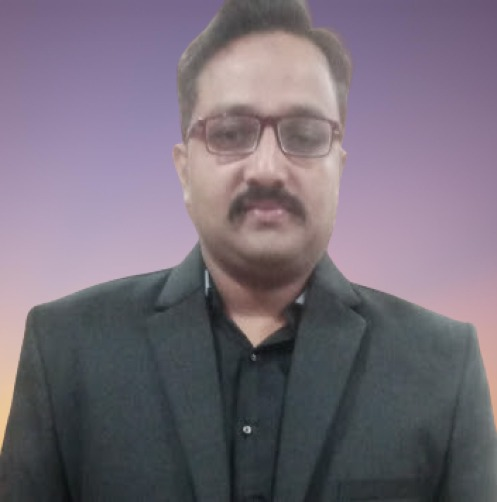

In [49]:
import PIL.Image

img = PIL.Image.open('/content/NAVEED-removebg-preview.jpg')
img

Use the `gemini-1.5-flash` model and pass the image to the model with `generate_content`.

In [50]:
model = genai.GenerativeModel("gemini-1.5-flash")

In [51]:
response = model.generate_content(img)

to_markdown(response.text)

> This is a photo of a man in a suit jacket. He is wearing glasses and has a mustache. He is looking at the camera.

To provide both text and images in a prompt, pass a list containing the strings and images:

In [29]:
response = model.generate_content(
    [
        "Write a short, engaging blog post based on this picture. It should include a description of the meal in the photo and talk about my journey meal prepping.",
        img,
    ],
    stream=True,
)
response.resolve()

In [30]:
to_markdown(response.text)

> ##  Meal Prep: My Newfound Freedom
> 
> This picture isn't just a delicious-looking lunch; it's a symbol of my new routine: meal prepping.  
> 
> For years, I'd dread the thought of cooking after work.  Between the commute, errands, and the never-ending to-do list, I'd often end up grabbing takeout or settling for a sad sandwich.  It wasn't just unhealthy; it was exhausting. 
> 
> Then, I decided to give meal prepping a try.  And let me tell you, it's been a game-changer! I spend a couple of hours on the weekend prepping a few healthy meals, and the result? Delicious, nutritious lunches like this one, ready to go in a flash. 
> 
> This particular creation features teriyaki chicken, rice, broccoli, and bell peppers. It's packed with protein, fiber, and all the nutrients to fuel my day.  
> 
> The best part? No more late-night takeout cravings.  It's amazing how much more energy I have when I'm eating well and not struggling with endless food decisions.  Meal prepping is my new superpower. 
> 
> **Do you meal prep?  What are your favorite go-to recipes?** 


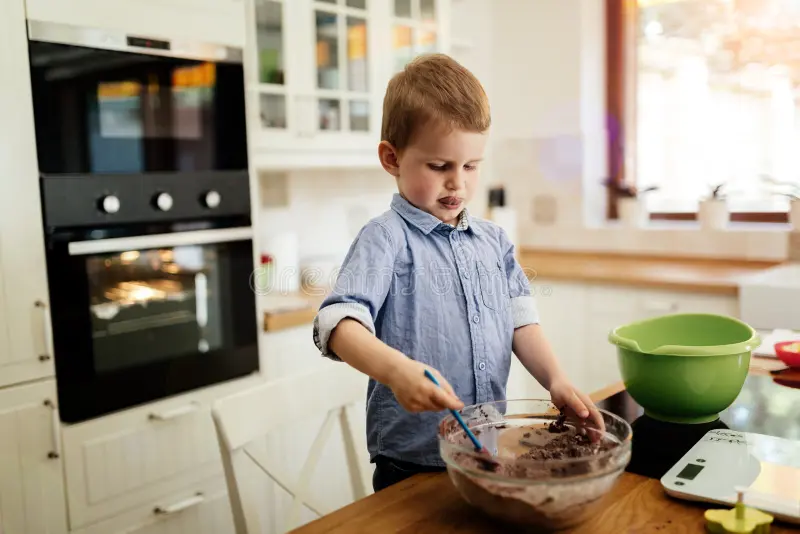

In [52]:
import PIL.Image

img = PIL.Image.open('/content/adorable-child-below-age-making-cookies-kitchen-133545805.webp')
img

In [53]:
model = genai.GenerativeModel("gemini-1.5-flash")

In [54]:
response = model.generate_content(img)

to_markdown(response.text)

> The boy is mixing the chocolate batter in the kitchen. He is using a blue spatula to mix the batter. The batter is in a clear glass bowl. There is a green bowl next to the batter, and a white scale is on the counter. The boy is wearing a blue shirt and has brown hair. The kitchen is clean and bright, with a white oven in the background.

In [55]:
response = model.generate_content(
    [
        "Write a short, engaging blog post based on this picture. It should include a description of the meal in the photo and talk about my journey meal prepping.",
        img,
    ],
    stream=True,
)
response.resolve()

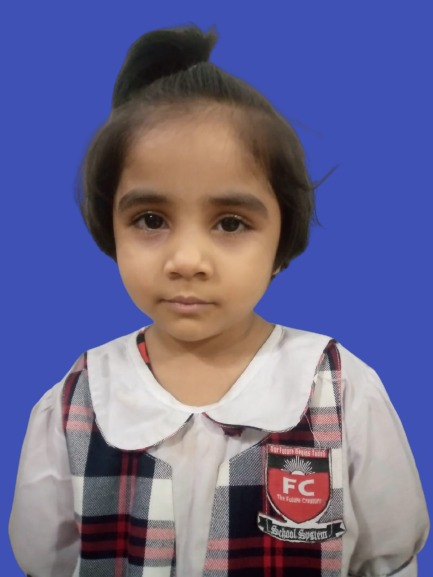

In [56]:
import PIL.Image

img = PIL.Image.open('/content/694a08c4-370c-44e8-b628-9818f389c418-removebg-preview (1).jpg')
img

In [59]:
model = genai.GenerativeModel("gemini-1.5-flash")

In [57]:
response = model.generate_content(
    [
        "Write a short, engaging blog post based on this picture. It should include a description of the meal in the photo and talk about my journey meal prepping.",
        img,
    ],
    stream=True,
)
response.resolve()

In [58]:
response = model.generate_content(img)

to_markdown(response.text)

> This is a photo of a young girl with dark brown hair. She is wearing a plaid shirt with a white collar. She has a serious expression on her face. The background is a solid blue color.

In [60]:
to_markdown(response.text)

> This is a photo of a young girl with dark brown hair. She is wearing a plaid shirt with a white collar. She has a serious expression on her face. The background is a solid blue color.

## Chat conversations

Gemini enables you to have freeform conversations across multiple turns. The `ChatSession` class simplifies the process by managing the state of the conversation, so unlike with `generate_content`, you do not have to store the conversation history as a list.

Initialize the chat:

In [31]:
model = genai.GenerativeModel("gemini-1.5-flash")
chat = model.start_chat(history=[])
chat

ChatSession(
    model=genai.GenerativeModel(
        model_name='models/gemini-1.5-flash',
        generation_config={},
        safety_settings={},
        tools=None,
        system_instruction=None,
        cached_content=None
    ),
    history=[]
)

The `ChatSession.send_message` method returns the same `GenerateContentResponse` type as <a href="https://github.com/google-gemini/generative-ai-python/blob/main/docs/api/google/generativeai/generate_text.md"><code>GenerativeModel.generate_content</code></a>. It also appends your message and the response to the chat history:

In [32]:
response = chat.send_message(
    "In one sentence, explain how a computer works to a young child."
)
to_markdown(response.text)

> A computer is like a brain that can follow instructions written in special codes, and it can use those instructions to do lots of cool things, like play games, show you pictures, and help you learn! 


In [33]:
chat.history

[parts {
   text: "In one sentence, explain how a computer works to a young child."
 }
 role: "user",
 parts {
   text: "A computer is like a brain that can follow instructions written in special codes, and it can use those instructions to do lots of cool things, like play games, show you pictures, and help you learn! \n"
 }
 role: "model"]

You can keep sending messages to continue the conversation. Use the `stream=True` argument to stream the chat:

In [34]:
response = chat.send_message(
    "Okay, how about a more detailed explanation to a high schooler?", stream=True
)

for chunk in response:
    print(chunk.text)
    print("_" * 80)

Computers
________________________________________________________________________________
 work by processing information, represented as ones and zeros, through a series of circuits
________________________________________________________________________________
 and components. They follow instructions called programs, which are essentially sets of rules telling the computer what
________________________________________________________________________________
 to do with the data, enabling them to perform a wide range of tasks like calculations, displaying graphics, and connecting to the internet. 

________________________________________________________________________________


[`genai.protos.Content`](https://github.com/google-gemini/generative-ai-python/blob/main/docs/api/google/generativeai/protos/Content.md) objects contain a list of [`genai.protos.Part`](https://github.com/google-gemini/generative-ai-python/blob/main/docs/api/google/generativeai/protos/Part.md) objects that each contain either a text (string) or inline_data ([`genai.protos.Blob`](https://github.com/google-gemini/generative-ai-python/blob/main/docs/api/google/generativeai/protos/Blob.md)), where a blob contains binary data and a `mime_type`. The chat history is available as a list of `genai.protos.Content` objects in `ChatSession.history`:

In [35]:
for message in chat.history:
    display(to_markdown(f"**{message.role}**: {message.parts[0].text}"))

> **user**: In one sentence, explain how a computer works to a young child.

> **model**: A computer is like a brain that can follow instructions written in special codes, and it can use those instructions to do lots of cool things, like play games, show you pictures, and help you learn! 


> **user**: Okay, how about a more detailed explanation to a high schooler?

> **model**: Computers work by processing information, represented as ones and zeros, through a series of circuits and components. They follow instructions called programs, which are essentially sets of rules telling the computer what to do with the data, enabling them to perform a wide range of tasks like calculations, displaying graphics, and connecting to the internet. 


## Count tokens

Large language models have a context window, and the context length is often measured in terms of the **number of tokens**. With the Gemini API, you can determine the number of tokens per any `genai.protos.Content` object. In the simplest case, you can pass a query string to the `GenerativeModel.count_tokens` method as follows:

In [42]:
model.count_tokens("What is the meaning of life?")

total_tokens: 7

Similarly, you can check `token_count` for your `ChatSession`:

In [ ]:
model.count_tokens(chat.history)

total_tokens: 501

## Advanced use cases

The following sections discuss advanced use cases and lower-level details of the Python SDK for the Gemini API.

### Use embeddings

[Embedding](https://developers.google.com/machine-learning/glossary#embedding-vector) is a technique used to represent information as a list of floating point numbers in an array. With Gemini, you can represent text (words, sentences, and blocks of text) in a vectorized form, making it easier to compare and contrast embeddings. For example, two texts that share a similar subject matter or sentiment should have similar embeddings, which can be identified through mathematical comparison techniques such as cosine similarity. For more on how and why you should use embeddings, refer to the [Embeddings guide](https://ai.google.dev/docs/embeddings_guide).

Use the `embed_content` method to generate embeddings. The method handles embedding for the following tasks (`task_type`):

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting. Using this task type requires a `title`.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

The following generates an embedding for a single string for document retrieval:

In [41]:
result = genai.embed_content(
    model="models/text-embedding-004",
    content="What is the meaning of life?",
    task_type="retrieval_document",
    title="Embedding of single string",
)

# 1 input > 1 vector output
print(str(result["embedding"])[:50], "... TRIMMED]")

[-0.028545432, 0.044588123, -0.03419736, -0.004266 ... TRIMMED]


Note: The `retrieval_document` task type is the only task that accepts a title.

To handle batches of strings, pass a list of strings in `content`:

In [40]:
result = genai.embed_content(
    model="models/text-embedding-004",
    content=[
        "What is the meaning of life?",
        "How much wood would a woodchuck chuck?",
        "How does the brain work?",
    ],
    task_type="retrieval_document",
    title="Embedding of list of strings",
)

# A list of inputs > A list of vectors output
for v in result["embedding"]:
    print(str(v)[:50], "... TRIMMED ...")

[-0.036453035, 0.03325499, -0.03970925, -0.0026286 ... TRIMMED ...
[-0.01591948, 0.032582667, -0.081024624, -0.011298 ... TRIMMED ...
[0.00037063262, 0.03763057, -0.12269569, -0.009518 ... TRIMMED ...


While the `genai.embed_content` function accepts simple strings or lists of strings, it is actually built around the `genai.protos.Content` type (like <a href="https://ai.google.dev/api/python/google/generativeai/GenerativeModel#generate_content"><code>GenerativeModel.generate_content</code></a>). `genai.protos.Content` objects are the primary units of conversation in the API.

While the `genai.protos.Content` object is multimodal, the `embed_content` method only supports text embeddings. This design gives the API the *possibility* to expand to multimodal embeddings.

In [39]:
response.candidates[0].content

parts {
  text: "Computers work by processing information, represented as ones and zeros, through a series of circuits and components. They follow instructions called programs, which are essentially sets of rules telling the computer what to do with the data, enabling them to perform a wide range of tasks like calculations, displaying graphics, and connecting to the internet. \n"
}
role: "model"

In [66]:
result = genai.embed_content(
    model="models/text-embedding-004", content=response.candidates[0].content
)

# 1 input > 1 vector output
print(str(result["embedding"])[:50], "... TRIMMED ...")

[-0.004395998, 0.009424992, -0.026494805, -0.00882 ... TRIMMED ...


Similarly, the chat history contains a list of `genai.protos.Content` objects, which you can pass directly to the `embed_content` function:

In [67]:
chat.history

[parts {
   text: "In one sentence, explain how a computer works to a young child."
 }
 role: "user",
 parts {
   text: "A computer is like a brain that can follow instructions written in special codes, and it can use those instructions to do lots of cool things, like play games, show you pictures, and help you learn! \n"
 }
 role: "model",
 parts {
   text: "Okay, how about a more detailed explanation to a high schooler?"
 }
 role: "user",
 parts {
   text: "Computers work by processing information, represented as ones and zeros, through a series of circuits and components. They follow instructions called programs, which are essentially sets of rules telling the computer what to do with the data, enabling them to perform a wide range of tasks like calculations, displaying graphics, and connecting to the internet. \n"
 }
 role: "model"]

In [68]:
result = genai.embed_content(model="models/text-embedding-004", content=chat.history)

# 1 input > 1 vector output
for i, v in enumerate(result["embedding"]):
    print(str(v)[:50], "... TRIMMED...")

[-0.03417175, 0.005179209, -0.054957863, -0.030872 ... TRIMMED...
[-0.027653022, 0.02506082, -0.037455544, 0.0112563 ... TRIMMED...
[0.032410417, 0.036596797, -0.04735078, -0.0301925 ... TRIMMED...
[-0.028266737, 0.015236765, -0.060119446, -0.03092 ... TRIMMED...


### Safety settings

The `safety_settings` argument lets you configure what the model blocks and allows in both prompts and responses. By default, safety settings block content with medium and/or high probability of being unsafe content across all dimensions. Learn more about [Safety settings](https://ai.google.dev/docs/safety_setting).

Enter a questionable prompt and run the model with the default safety settings, and it will not return any candidates:

In [69]:
response = model.generate_content("[Questionable prompt here]")
response.candidates

[content {
  parts {
    text: "Please provide me with the prompt so I can assist you. I understand that you may have concerns about the prompt being questionable. I\'m here to help you understand why a prompt might be considered questionable and to offer alternative prompts that are safe and ethical. \n\nRemember, I am programmed to be helpful and harmless. I will do my best to understand your request and provide you with the information you need. \n"
  }
  role: "model"
}
finish_reason: STOP
index: 0
safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}
]

The `prompt_feedback` will tell you which safety filter blocked the prompt:

In [65]:
response.prompt_feedback

Now provide the same prompt to the model with newly configured safety settings, and you may get a response.

In [70]:
response = model.generate_content(
    "[Questionable prompt here]", safety_settings={"HARASSMENT": "block_none"}
)
response.text

"I understand you're asking a question. However, I'm designed to be a helpful and harmless AI assistant. As such, I cannot generate responses that are harmful, unethical, or promote illegal activities. \n\nIf you'd like to ask a different question that aligns with my ethical guidelines, I'd be happy to help! \n\nLet's focus on creating positive and constructive content. \n"

Also note that each candidate has its own `safety_ratings`, in case the prompt passes but the individual responses fail the safety checks.

### Encode messages

The previous sections relied on the SDK to make it easy for you to send prompts to the API. This section offers a fully-typed equivalent to the previous example, so you can better understand the lower-level details regarding how the SDK encodes messages.

The [`google.generativeai.protos`](https://ai.google.dev/api/python/google/generativeai/protos) submodule provides access to the low level classes used by the API behind the scenes:

The SDK attempts to convert your message to a `genai.protos.Content` object, which contains a list of `genai.protos.Part` objects that each contain either:

1. a <a href="https://www.tensorflow.org/text/api_docs/python/text"><code>text</code></a> (string)
2. `inline_data` (`genai.protos.Blob`), where a blob contains binary `data` and a `mime_type`.

You can also pass any of these classes as an equivalent dictionary.

Note: The only accepted mime types are some image types, `image/*`.

So, the fully-typed equivalent to the previous example is:  

In [71]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(
    genai.protos.Content(
        parts=[
            genai.protos.Part(
                text="Write a short, engaging blog post based on this picture."
            ),
            genai.protos.Part(
                inline_data=genai.protos.Blob(
                    mime_type="image/jpeg", data=pathlib.Path("image.jpg").read_bytes()
                )
            ),
        ],
    ),
    stream=True,
)

In [72]:
response.resolve()

to_markdown(response.text[:100] + "... [TRIMMED] ...")

> ## Lunchtime Inspiration: Teriyaki Chicken & Veggies
> 
> Who says healthy eating has to be boring? This... [TRIMMED] ...

### Multi-turn conversations

While the `genai.ChatSession` class shown earlier can handle many use cases, it does make some assumptions. If your use case doesn't fit into this chat implementation it's good to remember that `genai.ChatSession` is just a wrapper around <a href="https://ai.google.dev/api/python/google/generativeai/GenerativeModel#generate_content"><code>GenerativeModel.generate_content</code></a>. In addition to single requests, it can handle multi-turn conversations.

The individual messages are `genai.protos.Content` objects or compatible dictionaries, as seen in previous sections. As a dictionary, the message requires `role` and `parts` keys. The `role` in a conversation can either be the `user`, which provides the prompts, or `model`, which provides the responses.

Pass a list of `genai.protos.Content` objects and it will be treated as multi-turn chat:

In [73]:
model = genai.GenerativeModel("gemini-1.5-flash")

messages = [
    {
        "role": "user",
        "parts": ["Briefly explain how a computer works to a young child."],
    }
]
response = model.generate_content(messages)

to_markdown(response.text)

> Imagine a computer is like a really smart friend who can do lots of things! It has a brain called a **CPU** that thinks really fast. It also has a memory where it remembers things like your favorite games and songs.
> 
> You tell the computer what to do by using **buttons** and a **screen**, like talking to your friend. The computer then uses its brain to follow your instructions.
> 
> It can do things like:
> 
> * **Show you pictures and videos:**  Like showing you your favorite cartoon on the screen.
> * **Play games:**  Like making you jump and run around in an adventure.
> * **Help you learn:**  Like showing you how to spell your name.
> * **Talk to other people:**  Like letting you chat with your friends online.
> 
> The computer uses special **electricity** to make everything work. It's like magic, but it's actually science! 
> 
> So, next time you use a computer, remember it's just like a really smart friend who can do lots of fun things! 


To continue the conversation, add the response and another message.

Note: For multi-turn conversations, you need to send the whole conversation history with each request. The API is **stateless**.

In [74]:
messages.append({"role": "model", "parts": [response.text]})

messages.append(
    {
        "role": "user",
        "parts": [
            "Okay, how about a more detailed explanation to a high school student?"
        ],
    }
)

response = model.generate_content(messages)

to_markdown(response.text)

> Imagine a computer as a complex machine that takes your instructions and translates them into actions. It's like a super-powered calculator that can do much more than just add numbers. 
> 
> Here's a simplified breakdown:
> 
> **1. Input:** You interact with the computer through various **input devices** like a keyboard, mouse, or touchscreen. These devices translate your actions (typing, clicking, touching) into signals the computer understands.
> 
> **2. Processing:**  These signals are then sent to the **CPU (Central Processing Unit)**, the computer's "brain." It's a superfast chip that can process billions of instructions per second.  The CPU interprets the signals, analyzes them, and decides what to do. 
> 
> **3. Memory:**  The CPU uses **memory (RAM)** to store temporary data and instructions. This is like a notepad where the computer keeps track of what it's working on. 
> 
> **4. Storage:** For long-term data, the computer uses a **hard drive** or **solid-state drive (SSD)**. Think of it as a library where all your files, programs, and operating system are stored.
> 
> **5. Output:** The computer then sends the results of its processing to **output devices** like a monitor, speakers, or printer. These devices translate the computer's signals into things you can see, hear, or feel.
> 
> **Here's the magic:** The computer uses **binary code**, a language of 0s and 1s, to communicate with all its components.  Every instruction, every picture, every sound, is translated into this digital code.
> 
> **Think of it like this:** You're giving the computer a set of instructions in a language it understands (like typing on a keyboard). The CPU then translates those instructions into a language its internal components understand (binary code), and then executes them. This process happens extremely fast, giving the illusion of a "thinking" machine.
> 
> In essence, a computer is a system of interconnected components working together to process information and produce results based on your input. It's a fascinating world of complex operations happening at the speed of light! 


### Generation configuration

The `generation_config` argument allows you to modify the generation parameters. Every prompt you send to the model includes parameter values that control how the model generates responses.

In [75]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(
    "Tell me a story about a magic backpack.",
    generation_config=genai.types.GenerationConfig(
        # Only one candidate for now.
        candidate_count=1,
        stop_sequences=["x"],
        max_output_tokens=20,
        temperature=1.0,
    ),
)

In [76]:
text = response.text

if response.candidates[0].finish_reason.name == "MAX_TOKENS":
    text += "..."

to_markdown(text)

> Elara was a scrawny girl with a heart as big as the sky. She dreamt of...

## What's next

-   Prompt design is the process of creating prompts that elicit the desired response from language models. Writing well structured prompts is an essential part of ensuring accurate, high quality responses from a language model. Learn about best practices for [prompt writing](https://ai.google.dev/docs/prompt_best_practices).
-   Gemini offers several model variations to meet the needs of different use cases, such as input types and complexity, implementations for chat or other dialog language tasks, and size constraints. Learn about the available [Gemini models](https://ai.google.dev/models/gemini).
-   Gemini offers options for requesting [rate limit increases](https://ai.google.dev/docs/increase_quota). The rate limit for Gemini-Pro models is 60 requests per minute (RPM).